In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain, combinations
from datetime import datetime
import matplotlib.pyplot as plt

# Load

In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/MappingDf.csv') #매핑만 된 데이터
df['월'] = pd.to_datetime(df['일자']).dt.month
print(df.shape)
df

(129664, 17)


,지역,시간,발전량,일자,기온,강수량,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,PM10,PM25,월
0,전남 목포시,0,0.000,2013-01-01,-2.0,NaN,4.1,160.0,93.0,1021.4,NaN,NaN,3.0,2000.0,135.0,NaN,1
1,전남 목포시,1,0.000,2013-01-01,-2.2,NaN,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,44.0,NaN,1
2,전남 목포시,2,0.000,2013-01-01,-2.4,NaN,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,NaN,34.0,NaN,1
3,전남 목포시,3,0.000,2013-01-01,-2.7,NaN,3.6,160.0,95.0,1020.8,NaN,NaN,7.0,1800.0,41.0,NaN,1
4,전남 목포시,4,0.000,2013-01-01,-2.9,NaN,4.0,160.0,94.0,1020.0,NaN,NaN,7.0,1800.0,41.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129659,강원 강릉시,19,320.352,2020-12-31,-4.0,NaN,5.4,230.0,40.0,1020.0,NaN,NaN,0.0,4333.0,22.0,NaN,12
129660,강원 강릉시,20,342.336,2020-12-31,-4.3,NaN,6.4,230.0,41.0,1020.4,NaN,NaN,0.0,4853.0,24.0,NaN,12
129661,강원 강릉시,21,664.800,2020-12-31,-4.8,NaN,5.0,230.0,43.0,1021.3,NaN,NaN,0.0,3707.0,21.0,NaN,12
129662,강원 강릉시,22,692.736,2020-12-31,-4.9,NaN,5.3,230.0,42.0,1021.6,NaN,NaN,2.0,4694.0,32.0,NaN,12


In [6]:
df.isnull().sum()

지역           0
시간           0
발전량         18
일자           0
기온          48
강수량     117804
풍속          80
풍향         699
습도         496
해면기압       148
일조       58895
일사       58682
전운량      39188
시정        4378
PM10      9504
PM25     52199
월            0
dtype: int64

In [7]:
df.drop(columns='강수량', inplace=True) #대부분이 Null인 강수량 변수 삭제 
df.head(2)

,지역,시간,발전량,일자,기온,풍속,풍향,습도,해면기압,일조,일사,전운량,시정,PM10,PM25,월
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,NaN,3.0,2000.0,135.0,NaN,1
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,44.0,NaN,1


In [8]:
pm_idx = df[df['PM10'] == -999].index # PM10의 값이 -999이면 이상데이터 제거하기
print(len(pm_idx))
df.drop(pm_idx, axis=0, inplace=True)

547


# Rename a Variable

In [9]:
df.columns

Index(['지역', '시간', '발전량', '일자', '기온', '풍속', '풍향', '습도', '해면기압', '일조', '일사',
       '전운량', '시정', 'PM10', 'PM25', '월'],
      dtype='object')

In [10]:
cols_rename = {
    '지역' : 'Area',
    '시간' : 'Time',
    '발전량' : 'Photovoltaics',
    '일자' : 'Date',
    '기온' : 'Temperature',
    '풍속' : 'Wind velocity',
    '풍향' : 'Wind direction',
    '습도' : 'Humidity',
    '해면기압' : 'Sea-level pressure',
    '일조' : 'Sunshine',
    '일사' : 'Solar radiation',
    '전운량' : 'Cloudy',
    '시정' : 'Visibility',
    'PM10' : 'PM10',
    'PM25' : 'PM25',
    '월' : 'Month'
}

In [11]:
df.rename(columns = cols_rename, inplace=True)
df

,Area,Time,Photovoltaics,Date,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Solar radiation,Cloudy,Visibility,PM10,PM25,Month
0,전남 목포시,0,0.000,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,NaN,3.0,2000.0,135.0,NaN,1
1,전남 목포시,1,0.000,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,44.0,NaN,1
2,전남 목포시,2,0.000,2013-01-01,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,NaN,34.0,NaN,1
3,전남 목포시,3,0.000,2013-01-01,-2.7,3.6,160.0,95.0,1020.8,NaN,NaN,7.0,1800.0,41.0,NaN,1
4,전남 목포시,4,0.000,2013-01-01,-2.9,4.0,160.0,94.0,1020.0,NaN,NaN,7.0,1800.0,41.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129659,강원 강릉시,19,320.352,2020-12-31,-4.0,5.4,230.0,40.0,1020.0,NaN,NaN,0.0,4333.0,22.0,NaN,12
129660,강원 강릉시,20,342.336,2020-12-31,-4.3,6.4,230.0,41.0,1020.4,NaN,NaN,0.0,4853.0,24.0,NaN,12
129661,강원 강릉시,21,664.800,2020-12-31,-4.8,5.0,230.0,43.0,1021.3,NaN,NaN,0.0,3707.0,21.0,NaN,12
129662,강원 강릉시,22,692.736,2020-12-31,-4.9,5.3,230.0,42.0,1021.6,NaN,NaN,2.0,4694.0,32.0,NaN,12


# Monthly Distribution

In [12]:
area_name = ['Gn', 'Jj', 'Mp' ]
for idx, area in enumerate(['강원 강릉시','경남 진주시', '전남 목포시']):
  name = area_name[idx]
  data = df[df['Area'] == area]
  data.reset_index(drop=True, inplace=True)
  globals()[f'{name}_df'] = data
print(f'목포시 : {Mp_df.shape}\n진주시 : {Jj_df.shape}\n강릉시 : {Gn_df.shape}')

목포시 : (60796, 16)
진주시 : (33258, 16)
강릉시 : (35063, 16)


In [13]:
def Monthly_plot(area_df, col, name):
  day_list = area_df['Date'].unique()

  data = pd.DataFrame()
  for day in day_list:
    data_sum = area_df[area_df['Date'] == day][col].mean()
    sum_df = pd.DataFrame([[day, data_sum]], columns=['Date',f'{col}sum'])
    data = pd.concat([data, sum_df]).reset_index(drop=True)

  data['Month'] = data['Date'].str[5:7]
  data['Month'] = data['Month'].astype(int)

  #월별 sum 자료
  for i in range(1,13):
    date = datetime(year = 2013, month = i, day = 1)
    month = date.strftime('%b')
    globals()[month] = data[data['Month'].isin([i])][f'{col}sum'].to_numpy(int)

  fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
  m_list = np.array([Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec], dtype=object)

  ax.boxplot(m_list, showmeans=True)
  ax.set_xticks(range(1,13))
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
  ax.set_title(f"Average {name}", loc='center', fontsize=20, pad=15)
  ax.set_xlabel('month', fontsize=16)
  ax.set_ylabel(f'AVG {col}', fontsize=13)
  plt.show()

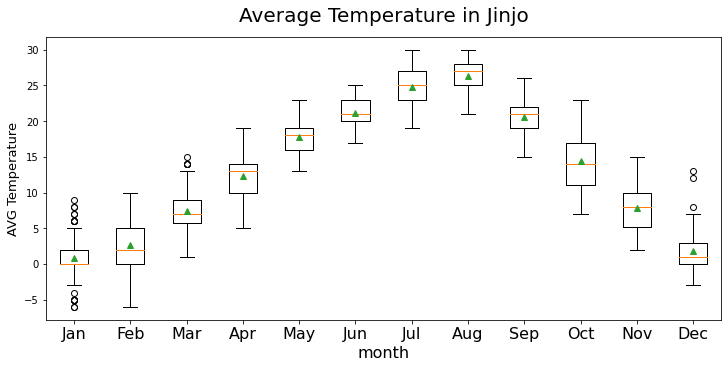

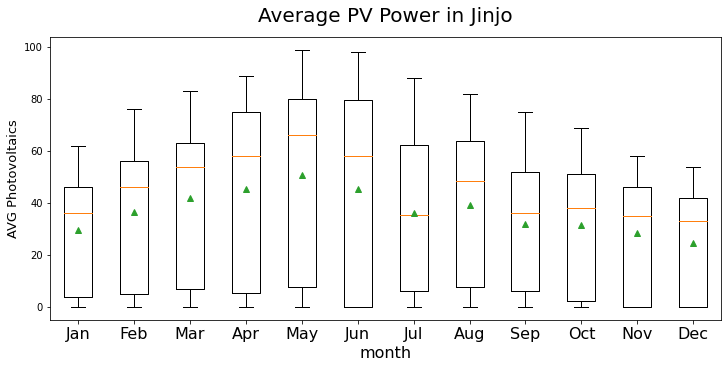

In [14]:
Monthly_plot(Jj_df, 'Temperature', 'Temperature in Jinjo')
Monthly_plot(Jj_df,'Photovoltaics', 'PV Power in Jinjo')

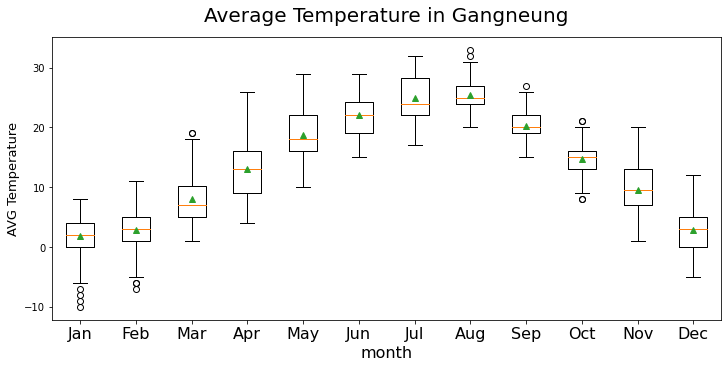

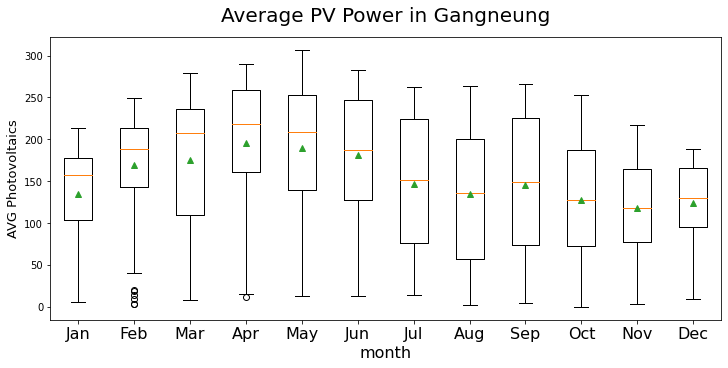

In [15]:
Monthly_plot(Gn_df, 'Temperature', 'Temperature in Gangneung')
Monthly_plot(Gn_df,'Photovoltaics', 'PV Power in Gangneung')

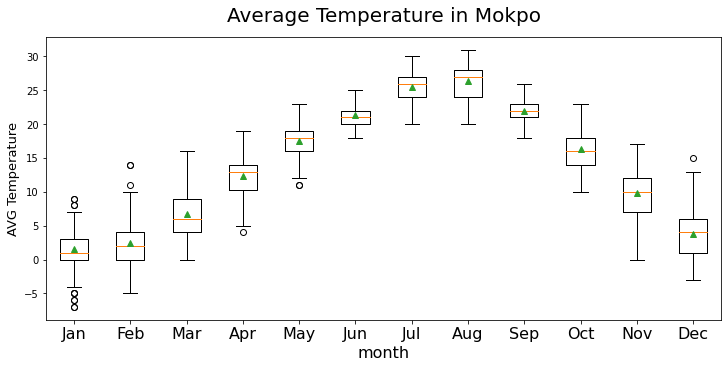

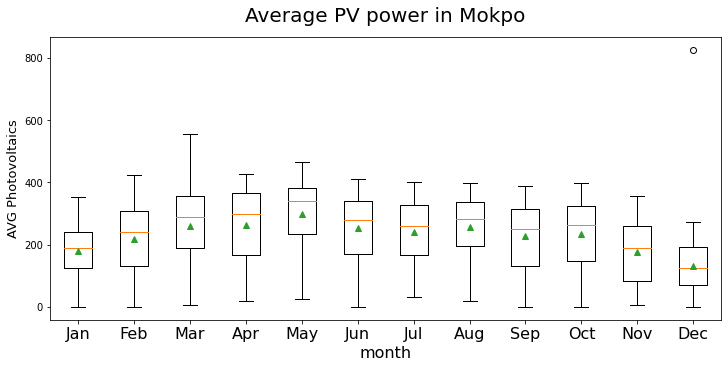

In [18]:
Monthly_plot(Mp_df, 'Temperature', 'Temperature in Mokpo')
Monthly_plot(Mp_df, 'Photovoltaics', 'PV power in Mokpo')

# Correlation analysis

## Area

In [35]:
def Correlation(area_df, cols, name):
  fig, ax = plt.subplots(figsize=(15,6))
  plt.title(f'{name} correlation', fontsize=15)
  
  data = area_df.copy()
  data = data[cols]

  corr_df = data.corr()
  mask = np.zeros_like(corr_df, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  sns.heatmap(corr_df, 
            cmap = 'RdBu_r', 
            annot = True,   
            mask = mask,
            linewidths = .5,
            cbar_kws = {"shrink": .8}, 
            vmin = -1,
            vmax = 1
             )  
  plt.xticks(rotation=25)
  plt.show()
  return corr_df

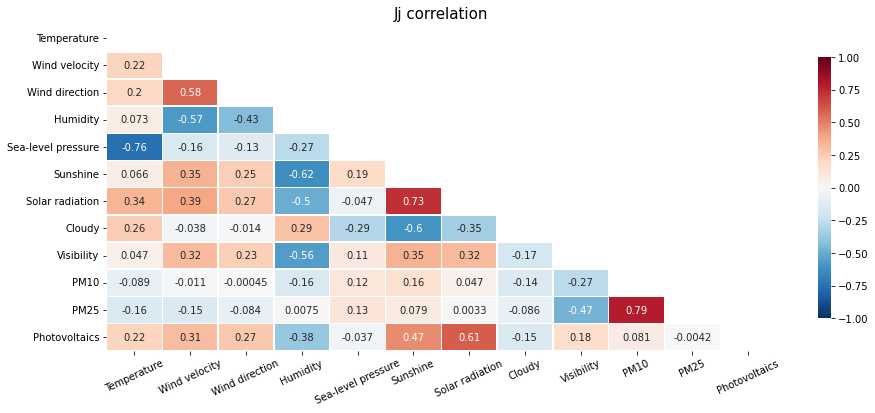

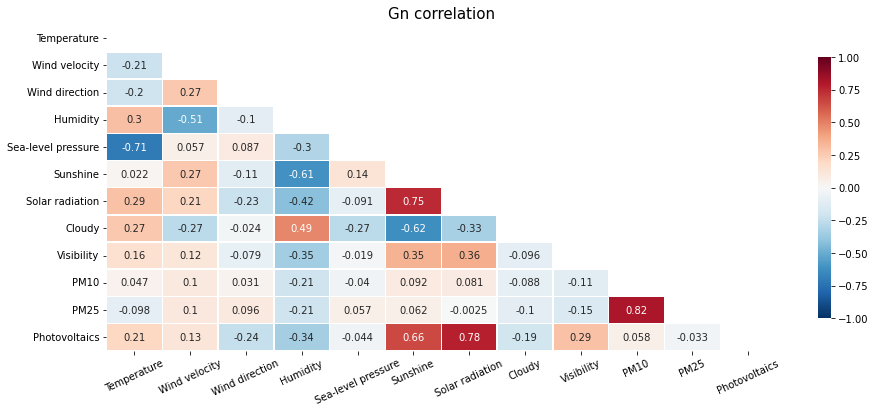

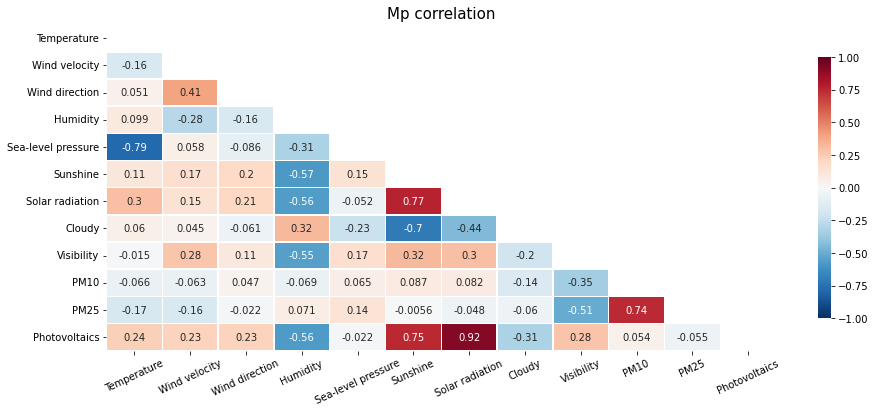

In [36]:
cols = ['Temperature', 'Wind velocity', 'Wind direction', 'Humidity', 'Sea-level pressure', 'Sunshine', 'Solar radiation', 'Cloudy', 'Visibility', 'PM10', 'PM25', 'Photovoltaics']
corr_Jj = Correlation(Jj_df, cols, 'Jj')
corr_Gn = Correlation(Gn_df, cols, 'Gn')
corr_Mp = Correlation(Mp_df, cols, 'Mp')

In [40]:
def CorrBar(corr_df, cols, area):
  #중복 제거한 변수 조합으로 상관관계 데이터 만들기
  Sublist = chain.from_iterable(combinations(cols,n) for n in range(2,3))
  data = pd.DataFrame(columns=["cols",'corr'])
  for c in Sublist:
    corr_num = corr_df.loc[c]
    add_df = pd.DataFrame([[c, corr_num]] , columns=["cols",'corr'])
    data = pd.concat([data, add_df])
  data.sort_values('corr', ascending=False, inplace=True)
  data.reset_index(inplace=True, drop=True)

  #상관계수 양,음수로 데이터 분리(0.1보다 작은 상관관계는 제외)
  pos_df = data[data['corr'] >= 0.1] 
  neg_df = data[data['corr'] < -0.1]

  #양,음 데이터로 각각 그래프 그리기
  fig, [ax1, ax2] = plt.subplots(figsize=(18,10), nrows=2, ncols=1)
  # sns.color_palette('blues', len(pos_df))
  bar1 = ax1.bar(range(0, len(pos_df)), pos_df['corr'], color=sns.color_palette('Reds_r', len(pos_df)))
  bar2 = ax2.bar(range(0, len(neg_df)), -neg_df['corr'], color=sns.color_palette('Blues', len(neg_df)))
  plt.suptitle(f'negative and positive correlation in {area}', fontsize=30)
  ax1.set_xticks(range(0, len(pos_df)))
  ax2.set_xticks(range(0, len(neg_df)))
  ax1.set_xticklabels([i for i in pos_df['cols'].str[0]], fontsize=14, rotation=-40)
  ax2.set_xticklabels([i for i in neg_df['cols'].str[0]], fontsize=14, rotation=-40)

  #라벨을 넣어줘서 연관관계 변수 표시 
  po_label = [i for i in pos_df['cols'].str[1]]
  ne_label = [i for i in neg_df['cols'].str[1]]
  for bar in [bar1,bar2]:
    if bar == bar1:
      label = po_label
      ax = ax1
    else:
      label = ne_label
      ax = ax2
    idx=0  
    for b in bar:
      x = b.get_x()
      y = b.get_height()
      ax.text(x , y, label[idx], va = 'bottom', fontsize=13)
      idx+=1
  plt.show()
  return data

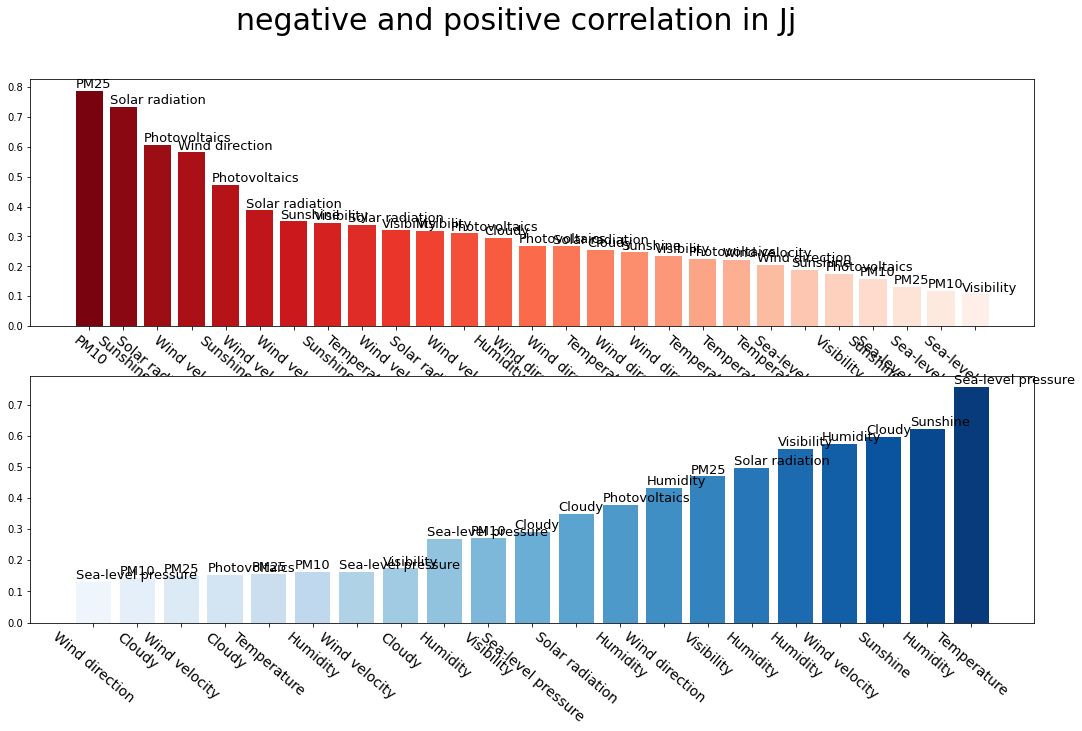

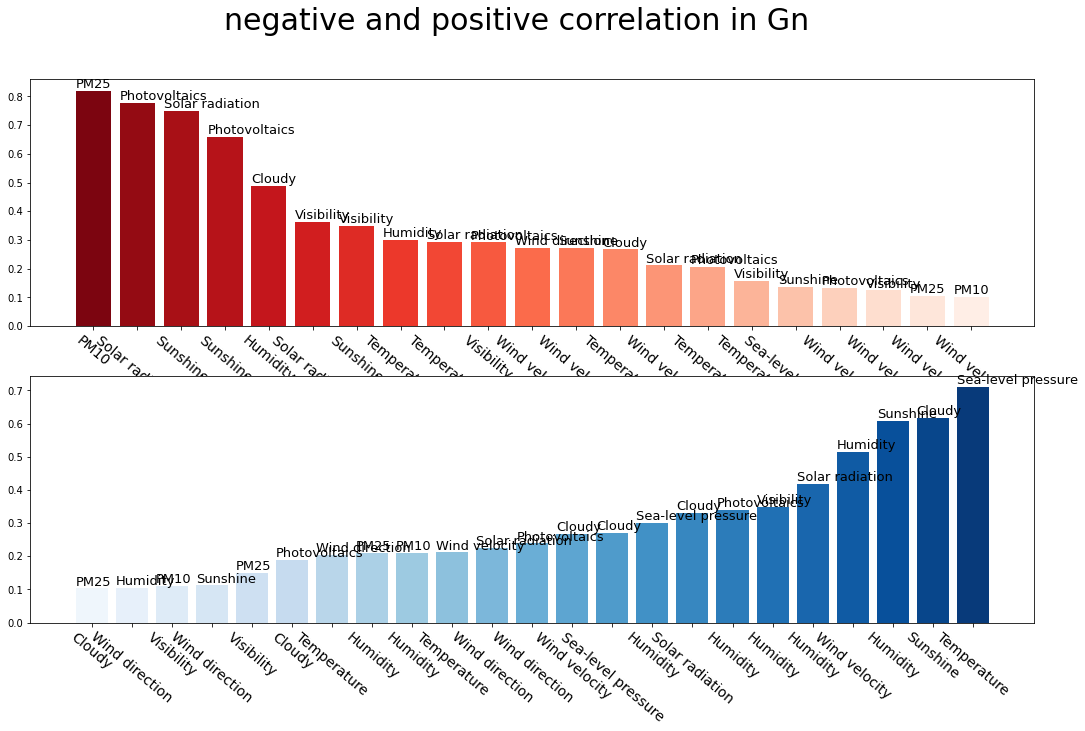

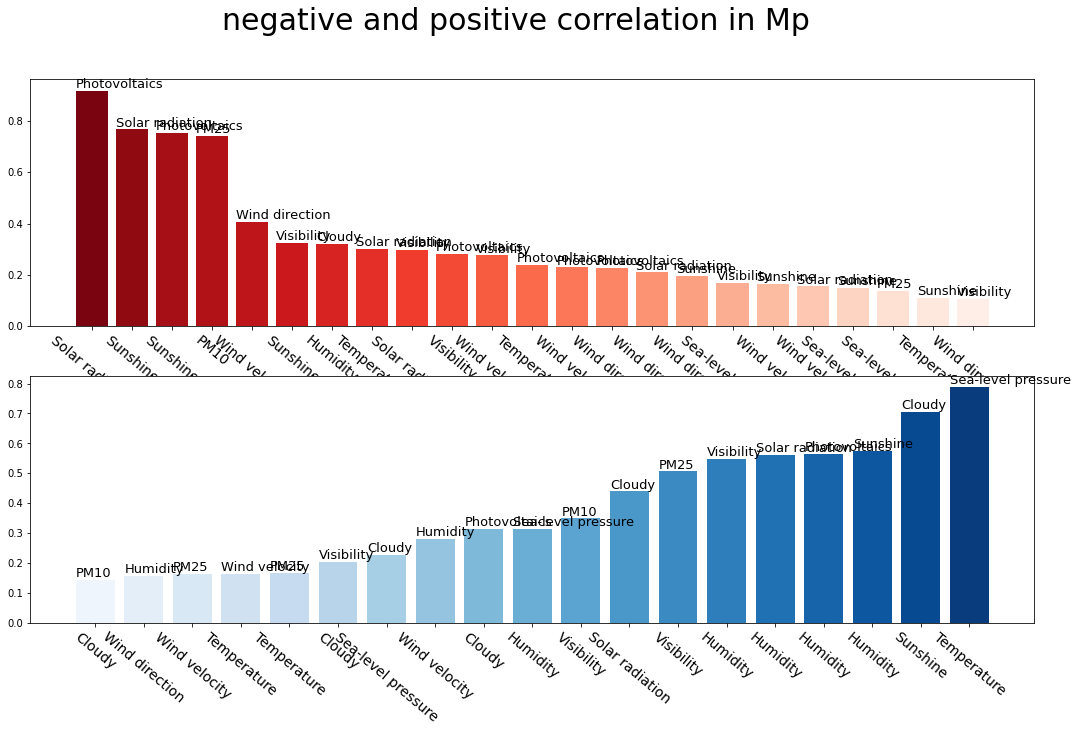

In [41]:
Jj_data = CorrBar(corr_Jj, cols, 'Jj')
Gn_data = CorrBar(corr_Gn, cols, 'Gn')
Mp_data = CorrBar(corr_Mp, cols, 'Mp')

In [42]:
Jj_data['Area'] = 'Jinjo'
Gn_data['Area'] = 'Gangneung'
Mp_data['Area'] = 'Mokpo'
corr_data = pd.concat([Jj_data,Mp_data,Gn_data], axis=1)
corr_data

,cols,corr,Area,cols,corr,Area,cols,corr,Area
0,"(PM10, PM25)",0.787854,Jinjo,"(Solar radiation, Photovoltaics)",0.917781,Mokpo,"(PM10, PM25)",0.819937,Gangneung
1,"(Sunshine, Solar radiation)",0.733836,Jinjo,"(Sunshine, Solar radiation)",0.767266,Mokpo,"(Solar radiation, Photovoltaics)",0.777456,Gangneung
2,"(Solar radiation, Photovoltaics)",0.605325,Jinjo,"(Sunshine, Photovoltaics)",0.753071,Mokpo,"(Sunshine, Solar radiation)",0.748925,Gangneung
3,"(Wind velocity, Wind direction)",0.581168,Jinjo,"(PM10, PM25)",0.742622,Mokpo,"(Sunshine, Photovoltaics)",0.659619,Gangneung
4,"(Sunshine, Photovoltaics)",0.473017,Jinjo,"(Wind velocity, Wind direction)",0.406227,Mokpo,"(Humidity, Cloudy)",0.487744,Gangneung
...,...,...,...,...,...,...,...,...,...
61,"(Humidity, Visibility)",-0.558763,Jinjo,"(Humidity, Solar radiation)",-0.560293,Mokpo,"(Humidity, Solar radiation)",-0.419236,Gangneung
62,"(Wind velocity, Humidity)",-0.572410,Jinjo,"(Humidity, Photovoltaics)",-0.564255,Mokpo,"(Wind velocity, Humidity)",-0.514536,Gangneung
63,"(Sunshine, Cloudy)",-0.596848,Jinjo,"(Humidity, Sunshine)",-0.573344,Mokpo,"(Humidity, Sunshine)",-0.607344,Gangneung
64,"(Humidity, Sunshine)",-0.620692,Jinjo,"(Sunshine, Cloudy)",-0.703862,Mokpo,"(Sunshine, Cloudy)",-0.618054,Gangneung


## Season

In [43]:
def SeasonSplit(area_df): 
  hot_season = pd.DataFrame()
  cold_season = pd.DataFrame()
  for i in range(5,11): #기온이 높은 5~11월
    idx = area_df[area_df['Month'] == i].index
    data = area_df.loc[idx]
    hot_season = pd.concat([hot_season,data])
  for i in [1,2,3,4,11,12]: #나머지 계절로 분리
    idx = area_df[area_df['Month'] == i].index
    data = area_df.loc[idx]
    cold_season = pd.concat([cold_season,data])
  hot_season.reset_index(drop=True, inplace=True)
  cold_season.reset_index(drop=True, inplace=True)
  return hot_season, cold_season

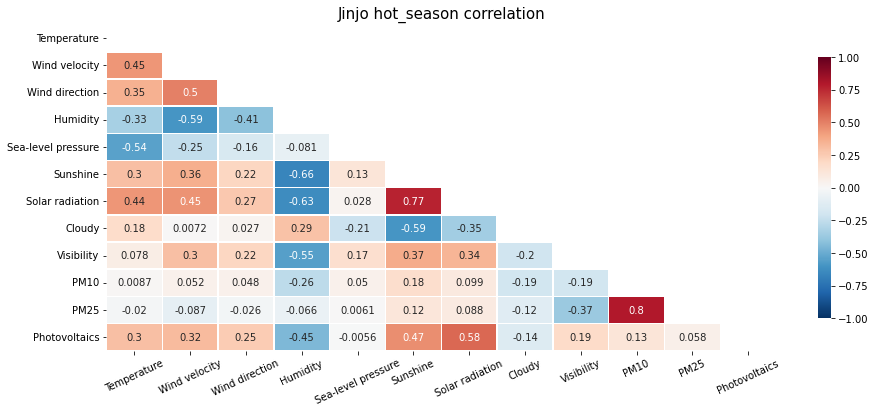

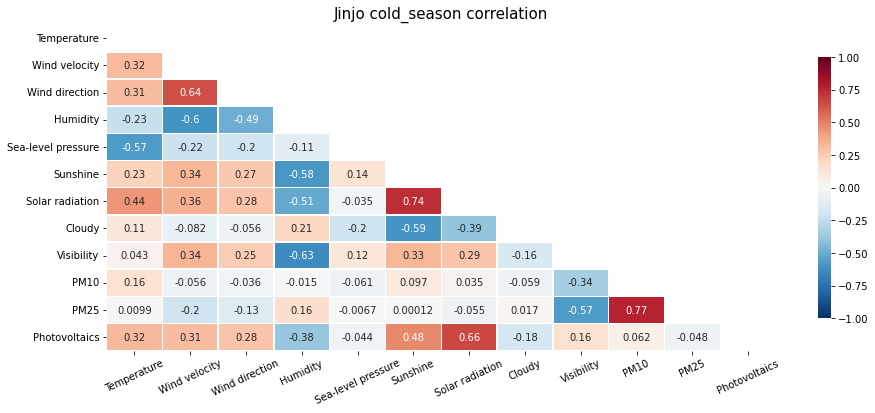

In [46]:
hot_season, cold_season = SeasonSplit(Jj_df)
h = Correlation(hot_season, cols, 'Jinjo hot_season')
c = Correlation(cold_season, cols, 'Jinjo cold_season')

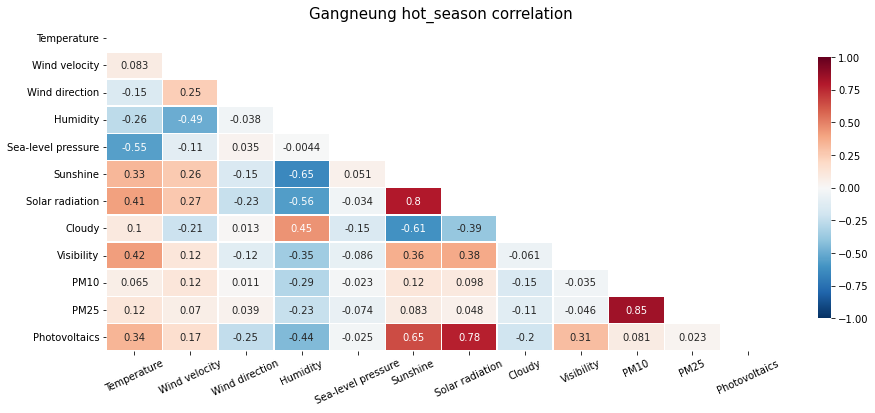

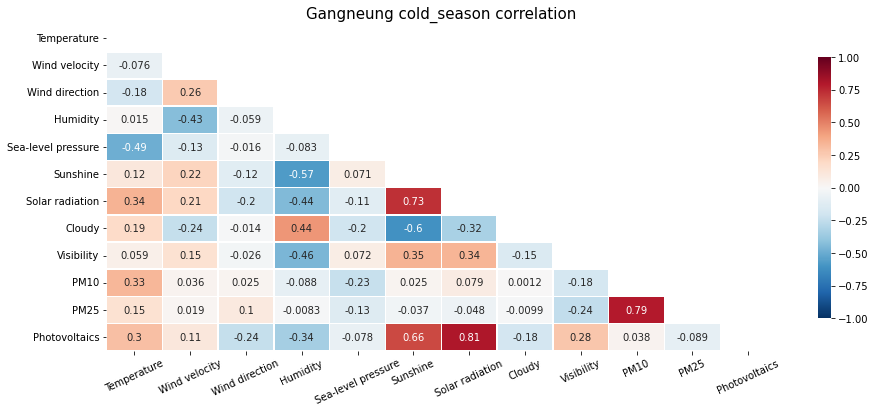

In [47]:
hot_season, cold_season = SeasonSplit(Gn_df)
h = Correlation(hot_season, cols, 'Gangneung hot_season')
c = Correlation(cold_season, cols, 'Gangneung cold_season')

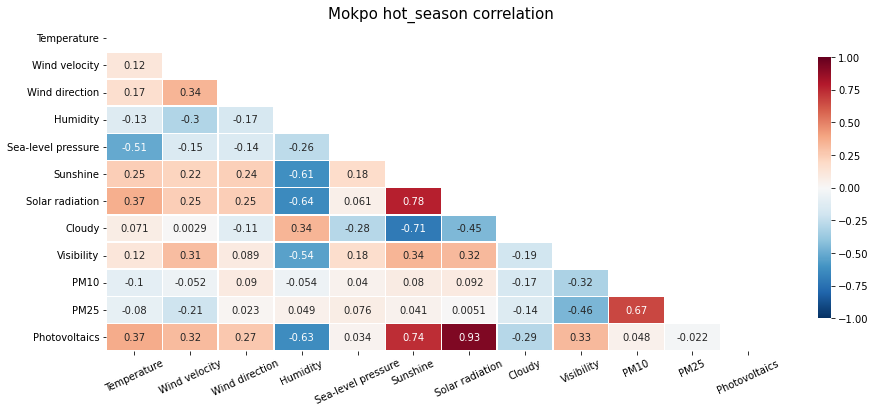

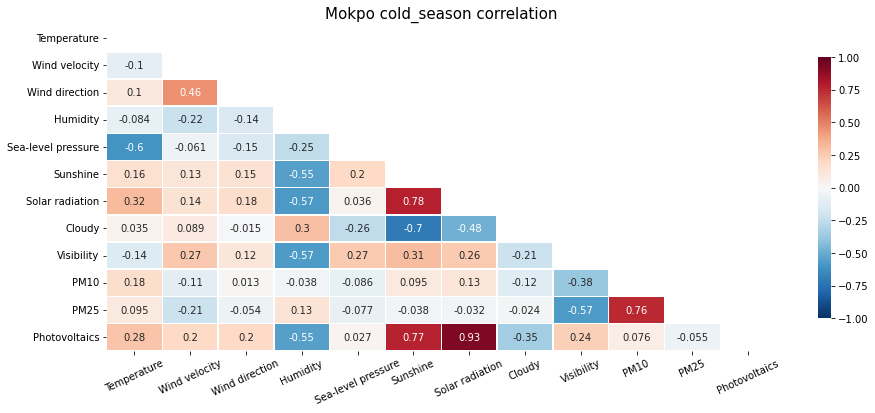

In [48]:
hot_season, cold_season = SeasonSplit(Mp_df)
h = Correlation(hot_season, cols, 'Mokpo hot_season')
c = Correlation(cold_season, cols, 'Mokpo cold_season')

# Save data

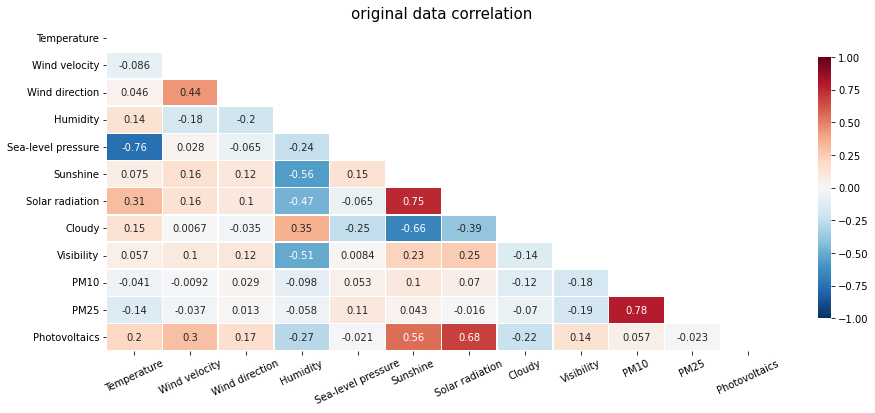

In [49]:
c = Correlation(df, cols, 'original data')

In [50]:
df.drop(columns =['Sunshine','PM25'], inplace=True) #상관관계가 높은 일조-일사 , PM25-PM10 변수들 중 하나씩 제거 
df.head(3)

,Area,Time,Photovoltaics,Date,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,PM10,Month
0,전남 목포시,0,0.0,2013-01-01,-2.0,4.1,160.0,93.0,1021.4,NaN,3.0,2000.0,135.0,1
1,전남 목포시,1,0.0,2013-01-01,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,44.0,1
2,전남 목포시,2,0.0,2013-01-01,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,34.0,1


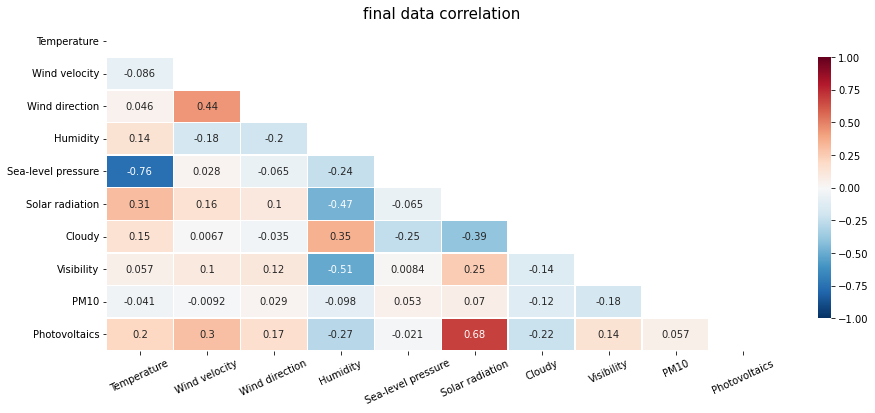

In [51]:
cols.remove('Sunshine')
cols.remove('PM25')
c = Correlation(df, cols, 'final data')

In [52]:
#상관관계가 높은 변수인 일조, PM25를 제거한 데이터
df.to_csv('/content/gdrive/MyDrive/SolarPower/DropColsData.csv', index=None) 